# FastScape

This is the barebones of the model developed by Prof Jean Braun (jeaun.braun@ujf-grenoble.fr) of [Université Grenoble Alps](http://www.univ-grenoble-alpes.fr/en/)' Institute of Earth Sciences ([ISTerre](https://isterre.fr/?lang=en)) that was partially implemented during a short course in early May 2016 at [Nelson Mandela Metropolitan University](http://www.nmmu.ac.za), organised by the [Africa Earth Observatory Network](http://aeon.org.za). The full model is implemented in Fortran, and can also be found in this repository as [fastscape.tar.gz](../braun_scripts/fastscape.tar.gz). (Note that requests for help with the full model should be directed to Prof Braun, not the repository owner.) It contains a lot more functionality, although this is essentially the kernel of it all.

The basic approach can be found in [Braun and Willet, 2012](http://dx.doi.org/10.1016/j.geomorph.2012.10.008) (paywall) but is summarised here anyway. More extensive notes and lecture slides compiled by Prof Braun can be found [here](../notes/).

## Background

Starting from a flat landscape you concentrate some water, which then starts to cut down into the landscape. The sides of a small channel becomes a localised slope, leading to failure. Most of the action is on the walls of the valley, but the driver is the stream in the valley base.

Valleys tend to get deeper over time, and downstream. Without uplift with respect to base level, you can not get incision. This uplift is some sort of tectonic process, and is what causes rivers which incise downwards.

### Rate of incision

This is proportional to:
* Slope
* Discharge (Volume of Water / unit time)

This can be written as follows:
\begin{equation}
\frac{\delta h}{\delta t} = U-k_{f}A^{m}S^{n}
\end{equation}
where $h =$ height, $t =$ time, $U =$ uplift, $S =$ slope, $A =$ catchment area, $k_f =$ fluvial erosion constant.

Some of these are constants: $K_f = 10^8$, $m/n = 0.4$. By convention, $n=1, m=0.4$, which means that the overall equation becomes almost entirely reliant on the area:
\begin{equation}
\frac{\delta h}{\delta t} = U-k_{f}A^{m=0.4}
\end{equation}
*Catchment* is the area of a landscape that drains through a given point.

This can be rewritten as:
\begin{equation}
\frac{\delta h}{\delta t} = U-k_{f}A^{m} \frac{\delta h}{\delta x}
\end{equation}
for a given point x. Tells us how the change in time changes in relation to the change in time. Greater change in $h$ leads to more rapid change in $t$. You need to have an initial condition, when $h( t = 0 )$ and step forward from there. This also means that change in height for the entire area does not affect things. The relative height of the landscape needs to be fixed as well: $(h(x = x_0) = h_0$ as a boundary condition. This fixed height is termed \emph{base level}, which is usually at sea level, although it is possible to get some local base-levels (lakes, reservoirs, &c).

Base level can be changed by either raising land or lowering sea level.

### Basic Approach

In order to model this, we will create a grid of heights, a la a digital elevation model. Then, the area around each node can be stored. The area of each node is $\delta x \times \delta y$, where each of these is the $\delta x = x_{length} / x_{number}$ and $\delta y = y_{length} / y_{number}$. For our model, $x_{length},y_{length} = 10000$m and $x_{number}, y_{number}$ varies, but will usually be at least 51 (giving 50 $\times$ 50 nodes in our grid).

## Coding it up

First, we need to set our constants and import what we need to import (the latter are mostly plotting and utility libraries: `matplotlib`, `numpy`, `Axes3D`.

#### A note to make things easier:
It is possible to convert the 2D grid to a single list or 1D array. This is done for a given node `i,j` which can then be referenced as `arr[ij]`. The general formula (used as-is in MATLAB, R, Fortran and other 1-indexed languages) is `ij = i+(j-1)*nx`, which in Python (and other zero-indexed languages like C, C++ and Java) becomes: `ij = i+j*nx`. Most of our array manipulation will be done using this approach.

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

debug = False
nx,ny = 51, 51 #size of the grid to be created
nn = nx*ny
xl, yl = 10000,10000 #overall size of model 
kf = 0.0001 #Fluvial erosion constant
kd = 10 #diffusion constant
n = 1 #by convention
m = 0.4 #by convention
u = 0.0002 #uplift per time step
dt = 10000 #time step in years
dx = xl/(nx-1) #change in x
dy = yl/(ny-1) #change in y

In order to create streams in various directions, we need to have changes in height across our grid. This means that we will create a grid with random heights:

In [2]:
#np.random.seed(123) #For checking that things are running the same each time.
h = []
for i in range(nn):
    h.append(np.random.random())

### Receivers

We now need to create the receiver array, which tells us where each node gives its water. If it gives water to itself, then it is either a base-level node or a local minima. To do this, the first thing we need to have is to work out the neighbours of each node. From there, we can calculate which neighbour has the steepest gradient, and therefore the receiver of the water that each node gets.

First we set up the receiver array to have each value as itself and the length for each node to its steepest neighbour to be zero.

Then we can calculate the values for each point. This is done by stepping through the grid and finding the global reference `ij`, which was discussed above.

Once `ij` is known, we can compute the distance to each neighbour of `ij`, which, in combination with the heights of the point and each of its neighbours, can be used to calculate the slope. The calculation is simply $slope = \frac{h_{ij} - h_{neighbour}}{distance}$.

This is a deeply nested loop: we want to go over each point in the overall grid (loop 1 and 2). We then have a point `ij` and using another two loops, check each of its eight neighbours (by doing loop 3 and loop 4 for -1, 0, 1 each). This allows us to easily get a global value `ijk` for each neighbour in turn:

    |i-1,j-1|i,j-1|i+1,j-1|
    | i-1,j | i,j | i+1,j |
    |i-1,j+1|i,j+1|i+1,j+1|

The slopes of `ij` to each `ijk` are compared and the maximum slope and the length to that `ijk` is stored.

In [3]:
def receiver(h, nn):
    rec_array = [i for i in range(nn)]
    length =  [0 for i in range(nn)]
    for i in range(1, nx-1): #loop 1
        for j in range(1, ny-1): #loop 2
            ij = i + j * nx
            max_slope = 0
            for ii in range(-1, 2): #check neighbours (loop 3)
                for jj in range(-1, 2): #check neighbours (loop 4)
                    ii_val = i + ii
                    jj_val = j + jj
                    ijk = ii_val + jj_val * nx
                    if ijk != ij:
                        distance = np.sqrt(((dx**2)*(ii**2))+((dy**2)*(jj**2)))
                        slope = (h[ij] - h[ijk]) / distance
                        if slope > max_slope:
                            max_slope = slope
                            rec_array[ij] = ijk
                            length[ij] = distance
    return (rec_array, length)

## Donors

From the previous, we have a list of where each node gives its water to. In this notebook's implementation, there is only ever one receiver for a given node (although it is possible to use a more sophisticated approach where the water is given proportionally to any nodes downslope according to which is the steepest (search for the D-infinity Algorithm if interested)).

However, there may be more than one donor to a given `ij`. There can be up to eight donors, in cases where `ij` is a local minima. This is equivalent to determining how many nodes have `ij` as a receiver.

As a matter of convention, a node that is its own receiver (and therefore a local or global base level) will not be listed as a donor of itself, nor increment the donor count.

This is an O(n^2) implementation, which works, but is relatively inefficient:

    donors = [[] for i in range(nn)]
    num_donors = [0 for i in range(nn)]

    for i in rec_array:
        for j in rec_array:
            if i != j:
                if rec_array[j] == rec_array[i]:
                    donors[i].append(j)
                    num_donors[i] += 1

This is a better, O(n) implementation. It works by getting each node to increment the count of the node it contains. It can then also add its own value to a list of (initially) empty lists of length 8.

In [4]:
def get_donors(rec_array, nn):
    num_donors = [0 for i in range(nn)]
    donors = [[0 for i in range(nn)] for j in range(8)]

    for ij in range(nn):
        if rec_array[ij] != ij:
            k = rec_array[ij]
            donors[num_donors[k]][k] = ij
            num_donors[k] += 1
    return (num_donors, donors)

## The Stack

Now we want to try and identify the nodes that are linked to each other, which we will do recursively.

1. First, we identify the base-level and local minima nodes.
    * This is the case when each node is its own receiver.
2. See its donors and go to each of their donors in turn.

This stack will be used for a variety of things later.

In [5]:
def find_stack(ij, stack, nstack, donors, num_donors, debug):
    '''
    Recursively put the donors of ij on the stack.
    '''
    for k in range(num_donors[ij]):
        if debug:
            print("ij:", ij, "k:", k, "nstack:", nstack)
        ijk = donors[k][ij]
        stack[nstack[0]] = ijk
        nstack[0] = nstack[0] + 1
        if debug:
            print ("Before: ",ij, "\t", k, "\t", nstack, "\n", stack) #Debugging comment
        find_stack(ijk, stack, nstack, donors, num_donors, debug)

def get_stack(rec_array, nn):
    nstack = [0]
    stack = [0 for i in range(nn)]
    for ij in range(nn):
        if rec_array[ij] == ij:
            stack[nstack[0]] = ij
            nstack[0] = nstack[0] + 1
            if debug:
                print("ij:", ij, "nstack:", nstack) #debugging comment
            find_stack(ij, stack, nstack, donors, num_donors, debug)
    return stack

## Area

In order to create the overall area of each catchment, we want to know the area that each node in the catchment receives. This area is the sum of the area of each donor node, so we want to give the area of a given node to its reciever. If this is done for each node, then the area of a given node will be what we want it to be.

Up until now, we have used the stack in normal order, ascending, but randomly spaced. If we reverse the stack, we can start at the highest points and sum all the values that each node gives to its receiver.

Note that Python allows for `stack.reverse()`, but this modifies it in place, and we want to preserve the original stack for later. If `stack.reverse()` is used, it needs to be used again before working with the original stack or you will have a bad time.

In [6]:
def reverse_stack(stack, nn):
    rev_stack = []
    for i in range(nn):
        if debug:
            print(nn-i-1, stack[nn-i-1])
        rev_stack.append(stack[nn-i-1])
    return rev_stack

def get_area(rev_stack, nn, rec_array):
    area = [dx*dy for i in range(nn)]

    for ij in rev_stack:
        if ij != rec_array[ij]:
            area[rec_array[ij]] = area[rec_array[ij]] + area[ij]
    return area

## The mathy bit

If we have a mesh with a known height $h$ for each $i$, $j$, we can use the first-order Taylor approximation:
\begin{equation}
f(x) = f(a) + (x-a)\frac{\delta f}{\delta x}(a)
\end{equation}
for a given $i$,$j$.

So, the Taylor approximations for our situation will be the following:
\begin{equation}
h_{i,1j} = h_{ij} + \Delta x \frac{\delta h}{\delta x} ij
\end{equation}
which means that the first order ( $
\frac{\delta h}{\delta x}ij \simeq \frac{h_{i+1j} - h_{ij}}{\Delta x}
$ )
and second order (
$
\frac{\delta^2 h}{\delta x^2}ij \simeq \frac{h_{i+1j} - h_{ij}}{\Delta x^2}
$ ) can be more easily computed.

So, what we will try and solve is an implicit method, using the following:
\begin{equation}
h_f(t + \Delta t) = h_{ij}(t) + U\Delta t - \frac{k_f \Delta t A_{ij}^m}{l_{ij}} \left[h_{ij} + \Delta h_{ij}\right]
\end{equation}

There is also an explicit solution, but this is harder to solve computationally.

## Using the Donor, Receiver and Stack

Given a mesh, with a stack calculated for the entire mesh, we know that a node on the boundary has nothing happening:
$h_1 = 0$. From there, we can move up the stack, using the receiver of a given node as the previous time.

Therefore, in the following:
\begin{equation}
h_f(t + \Delta t) = h_{ij}(t) + U\Delta t - \frac{k_f \Delta t A_{ij}^m}{l_{ij}} \left[h_{ij} + \Delta h_{ij}\right]
\end{equation}
let $F_{ij} = \frac{k_f \Delta t A_{ij}^m}{l_{ij}}$.
Then
\begin{equation}
h_f(t + \Delta t) = \frac{h_{ij}(t) + U\Delta t + F_{ij} h_{ij}}{1 - F}
\end{equation}
This works nicely, because for an arbitrarily small $\Delta t$ we get:
\begin{equation}
\lim_{\Delta t \rightarrow 0} = \frac{h_{ij}(t) + 0 + 0}{1 - 0}
\end{equation} which indicates that there has been no change.

For an arbitrarily large $\Delta t$, on the other hand:
\begin{equation}
\lim_{\Delta t \rightarrow \infty} = \frac{h_{ij}(t) + U\Delta t + F_{ij} h_{ij}}{1 - F}
\end{equation}
we erode to nothing (aka: Belgium).

### Implemention of the above
These equations are relatively easy to implement, since we can change `h` for each time step as we uplift.

In [7]:
def uplift(nx, ny, h, u, dt):
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            ij = i+j*nx
            h[ij] += u * dt
    return h

Eroding works similarly, but uses the value of the stack (which is the receiver of a given node in the stack). If a given recieving node is not a base level, it will erode down, based on the area of the nodes that are upstream of it.

(Note that if we had used `stack.reverse()` earlier, we would need to call it again before calling `erode()`.

In [8]:
def erode(stack, nn, m, kf, dt, length):
    for ij in range(nn):
        ijk = stack[ij]
        if rec_array[ijk] != ijk:
            f = area[ij]**m*kf*dt / length[ijk]
            h[ijk] = ( h[ijk] + f*h[rec_array[ijk]] ) / (1+f)
    return h

## Generating topography

In order to get our topography, we need to iterate through the previous process a number of times. Each time will raise the landscape and erode. On every iteration, we also need to recalculate the receiver array, the donor information, the stack, and area.

In [9]:
for i in range(100):
    rec_array, length = receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    #print (max(h), min(h), np.mean(h), np.median(h))

### Pretty Artworks!

So, now we want to actually be able to visualise what we have created.
This is easily done using `matplotlib`.

Because we have been using standard Python lists, we need to convert it to a numpy array. This can be easily reshaped back into our original grid using `np.reshape()` with the values of `nx` and `ny`.

We can also do this as a 3D plot, if we desire. This works better outside the notebook for some reason.

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    surf = ax.plot_surface(X,Y,to_plot,cmap='viridis')
    plt.show()

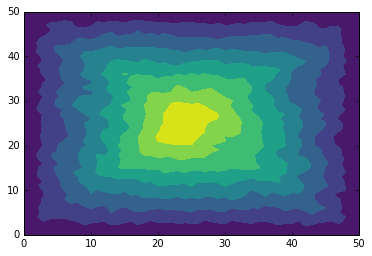

In [10]:
to_plot = np.array(h)
to_plot = np.reshape(h, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

## Cyclic Boundaries

We can treat the grid as infinite in one axis by changing the `reciever()` function to wrap on one axis. We also need to allow the `uplift()` function to include those boundaries.

So, instead of using the range 1 -- `nx-1`, we will use the full range of `nx`. Then we want to wrap the value back to 0 for values over `nx-1` and to `nx-1` for values less than 0. (Note that this can also be done for the y axis, using `ny` instead of `nx`.)

In [11]:
def cyc_receiver(h, nn):
    rec_array = [i for i in range(nn)]
    length =  [0 for i in range(nn)]
    for i in range(nx):
        for j in range(1, ny-1):
            ij = i + j * nx
            max_slope = 0
            for ii in range(-1, 2):
                for jj in range(-1, 2):
                    ii_val = i + ii
                    jj_val = j + jj
                    if ii_val > nx-1:
                        ii_val = 0
                    elif ii_val < 0:
                        ii_val = nx-1
                    ijk = ii_val + jj_val * nx
                    if ijk != ij:
                        distance = np.sqrt(((dx**2)*(ii**2))+((dy**2)*(jj**2)))
                        slope = (h[ij] - h[ijk]) / distance
                        if slope > max_slope:
                            max_slope = slope
                            rec_array[ij] = ijk
                            length[ij] = distance
    return (rec_array, length)

def cyc_uplift(nx, ny, h, u, dt):
    for i in range(nx):
        for j in range(1, ny-1):
            ij = i+j*nx
            h[ij] += u * dt
    return h

We can then repeat our earlier steps, only using our new `cyc_receiver()` and `cyc_uplift()` functions.

In [12]:
h = []
for i in range(nn):
    h.append(np.random.random())
    
for i in range(100):
    rec_array, length = cyc_receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = cyc_uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    #if i == 50:
    #    u = 0
    #print (max(h), min(h), np.mean(h), np.median(h))

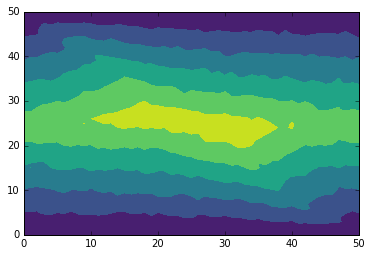

In [13]:
to_plot = np.array(h)
to_plot = np.reshape(h, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

It is is also possible to plot the value of the `area` rather than the value of the `height` at each point.

This gives us an indication of the discharge at a given point, essentially highlighting where the streams are.

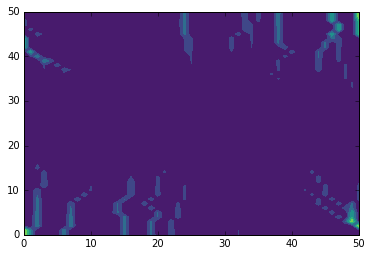

In [14]:
to_plot = np.array(area)
to_plot = np.reshape(area, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

## Diffusion
It can be noted that the resolution will affect the number of streams that are created in the model. This is a bad thing:

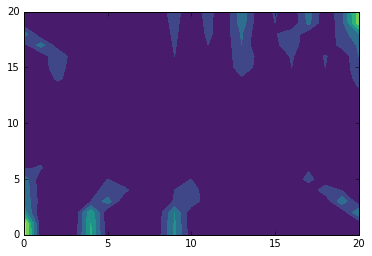

In [15]:
nx, ny = 21,21
nn = nx*ny

np.random.seed(123) #For checking that things are running the same each time.
h = []
for i in range(nn):
    h.append(np.random.random())

for i in range(100):
    rec_array, length = cyc_receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = cyc_uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    #print (max(h), min(h), np.mean(h), np.median(h))

to_plot = np.array(area)
to_plot = np.reshape(area, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

This will take longer to run, because of the larger grid, but plotting the area array shows that the number of streams varies.

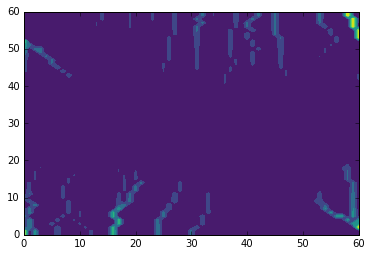

In [16]:
nx, ny = 61,61
nn = nx*ny

np.random.seed(123) #For checking that things are running the same each time.
h = []
for i in range(nn):
    h.append(np.random.random())

for i in range(100):
    rec_array, length = cyc_receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = cyc_uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    #print (max(h), min(h), np.mean(h), np.median(h))

to_plot = np.array(area)
to_plot = np.reshape(area, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

### Solution 

In order to eliminate this reliance on resolution, we will allow for diffusion of material off the slopes.

This uses the well-known diffusion equation:
\begin{equation}
\frac{\delta h}{\delta t} = K_D\frac{\delta^2 h}{\delta x^2}
\end{equation} for $h(x=0) = 0, h(x=l) = 0, h(t=0) = ?$

Explicit $\rightarrow$ Diffusion  
$\Delta t << \tau$ (the charactistic time scale)

Characteristic diffusion time scale:
$\begin{equation}\tau = \frac{L^2}{K_D} = \frac{{x_l}^2}{K_D}\end{equation}$

So, we want to get this to be dimensionless by dividing each dimensioned variable by a characteristic unit:
$\begin{equation}h' = h/H, x' = x/L, t' = t/\tau\end{equation}$

By letting $\tau = \frac{L^2}{K_D}$, we can simplify things to:
\begin{equation}
\frac{h'}{\delta t'} = K_D\frac{\delta^2 h'}{\delta x'^2}
\end{equation}

$\tau$ here is the diffusion time scale, and will indicate the amount of time that it would take to erode a given hill.
For the model we have, $L^2$ is 100km $\times$ 100km ($10^9$), and $\tau$ is:
$\frac{{10^5}^2}{10} << 10^9$

As can be seen, our $\Delta t$ is much smaller, so this should work for us.

In [17]:
def diffusion(h, nn, kd, dx, dy):
    #stuff for diffusion:
    hp = []
    hp = [h[ij] for ij in range(nn)]
    
    fact_x = dt*kd/dx**2
    fact_y = dt*kd/dy**2
    
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            ipj = i+j*nx
            imj = -i+j*nx
            ijp = i+(j+1)*nx
            if ijp > ny-1:
                ijp = 0
            elif ijp < 0:
                ijp = ny-1
            ijm = i+(j-1)*nx
            if ijm < 0:
                ijm = ny-1
            h[ij] = h[ij] + fact_x * ( hp[ipj] - 2*hp[ij] + hp[ijm] ) + fact_y * ( hp[ijp] - 2*hp[ij] + hp[ijm] )
    
    return h

Including this should make the number of streams that the model generates more stable, even with different `nx, ny` values:

In [18]:
nx, ny = 31,31
nn = nx*ny

np.random.seed(10) #For checking that things are running the same each time.
h = []
for i in range(nn):
    h.append(np.random.random())

for i in range(100):
    rec_array, length = cyc_receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = cyc_uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    h = diffusion(h, nn, kd, dx, dy)
    #print (max(h), min(h), np.mean(h), np.median(h))

C:\Users\S214382818\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Users\S214382818\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars


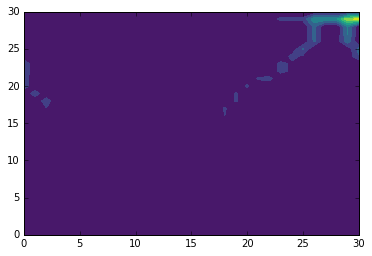

In [19]:
to_plot = np.array(area)
to_plot = np.reshape(area, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

This will take longer to run, because of the larger grid, but plotting the area shows that the number of streams is stable. The resolution with the larger grid is much better though.

In [20]:
nx, ny = 101,101
nn = nx*ny

np.random.seed(10) #For checking that things are running the same each time.
h = []
for i in range(nn):
    h.append(np.random.random())

for i in range(100):
    rec_array, length = cyc_receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = cyc_uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    h = diffusion(h, nn, kd, dx, dy)
    #print (max(h), min(h), np.mean(h), np.median(h))

C:\Users\S214382818\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Users\S214382818\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars


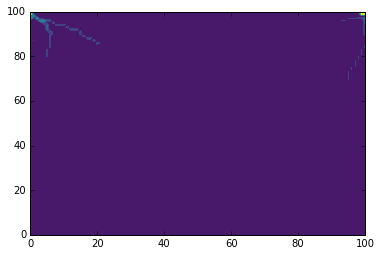

In [21]:
to_plot = np.array(area)
to_plot = np.reshape(area, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

### Another caveat regarding explicit modelling

When using explicit models, we have to satisfy the *Courant condition*:
$\Delta t < \frac{\Delta x^2}{\kappa_d}$

For our model with `nx,ny` = 50:
$\Delta t$ must be $ < \frac{{2\times10^3}^2}{10}$, so a time step of 10,000 years is reasonable.

As you increase the resolution of the mesh, then you need to at some point also increase your time step. If this is not done, things become unstable, and the model becomes useless.

#### However...
... while the implicit solution is immune to this instability, it is much slower to try and solve.

### A final note:
You need to validate a model. The best way is to solve a problem where there is a known solution. If your model gives you the correct answer, there is a good chance that the model is correct.

For the diffusion equation, the $\sin$ of the equation should also be sinusoidal, so this makes a good test.